In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!pip install rasterio

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 87.5 MB/s eta 0:00:00


In [ ]:
# import numpy as np
# import torch
# import rasterio
# import zipfile
# from io import BytesIO

# def preprocess_patches(cloudy_zip, clear_zip,
#                        patch_size=256, patches_per_image=100,
#                        out_file="/content/dataset.pt",
#                        min_cloud_fraction=0.01):  # min 1% cloud in cloudy patch

#     data_x, data_y, data_mask = [], [], []

#     with zipfile.ZipFile(cloudy_zip) as zc, zipfile.ZipFile(clear_zip) as zn:
#         cloudy_files = [f for f in zc.namelist() if f.endswith(".tif")]
#         clear_files  = [f for f in zn.namelist() if f.endswith(".tif")]

#         assert len(cloudy_files) == len(clear_files), "Mismatch in number of TIFF files"

#         for cf, nf in zip(cloudy_files, clear_files):
#             with zc.open(cf) as f_c, zn.open(nf) as f_n:
#                 with rasterio.open(BytesIO(f_c.read())) as src_c, rasterio.open(BytesIO(f_n.read())) as src_n:
#                     H, W = src_c.height, src_c.width

#                     patches_generated = 0
#                     attempts = 0
#                     while patches_generated < patches_per_image and attempts < patches_per_image * 10:
#                         attempts += 1

#                         # Random patch coordinates
#                         i = np.random.randint(0, H - patch_size)
#                         j = np.random.randint(0, W - patch_size)
#                         window = rasterio.windows.Window(j, i, patch_size, patch_size)

#                         # Read RGB bands
#                         cloudy_patch = src_c.read([1,2,3], window=window).astype(np.float32)
#                         clear_patch  = src_n.read([1,2,3], window=window).astype(np.float32)

#                         # Cloud mask from cloudy patch
#                         cloud_mask = np.isnan(cloudy_patch[0]).astype(np.float32)
#                         cloud_mask = np.expand_dims(cloud_mask, axis=0)

#                         cloud_fraction = cloud_mask.sum() / (patch_size*patch_size)

#                         # Skip patch if cloudy patch has no clouds
#                         if cloud_fraction < min_cloud_fraction:
#                             continue

#                         # Skip patch if clear patch has any clouds
#                         if np.isnan(clear_patch[0]).sum() > 0:
#                             continue

#                         # Replace NaNs in cloudy image with 0
#                         cloudy_patch = np.nan_to_num(cloudy_patch, nan=0.0)
#                         clear_patch  = np.nan_to_num(clear_patch, nan=0.0)

#                         # Normalize RGB to 0-1
#                         cloudy_patch /= 10000.0
#                         clear_patch  /= 10000.0

#                         # Clip to [0,1]
#                         cloudy_patch = np.clip(cloudy_patch, 0.0, 1.0)
#                         clear_patch  = np.clip(clear_patch, 0.0, 1.0)

#                         # Save valid patch
#                         data_x.append(torch.tensor(cloudy_patch, dtype=torch.float32))
#                         data_y.append(torch.tensor(clear_patch, dtype=torch.float32))
#                         data_mask.append(torch.tensor(cloud_mask, dtype=torch.float32))

#                         patches_generated += 1

#     # Save all patches
#     torch.save({
#         "x": torch.stack(data_x),
#         "y": torch.stack(data_y),
#         "mask": torch.stack(data_mask)
#     }, out_file)

#     print(f"✅ Saved {len(data_x)} patches to {out_file}")


In [ ]:
import numpy as np
import torch
import rasterio
import zipfile
from io import BytesIO

def preprocess_patches(cloudy_zip, clear_zip,
                       patch_size=256, patches_per_image=100,
                       out_file="/content/dataset.pt",
                       min_cloud_fraction=0.01):  # min 1% cloud in cloudy patch

    data_x, data_y, data_mask = [], [], []

    with zipfile.ZipFile(cloudy_zip) as zc, zipfile.ZipFile(clear_zip) as zn:
        cloudy_files = [f for f in zc.namelist() if f.endswith(".tif")]
        clear_files  = [f for f in zn.namelist() if f.endswith(".tif")]

        assert len(cloudy_files) == len(clear_files), "Mismatch in number of TIFF files"

        for cf, nf in zip(cloudy_files, clear_files):
            with zc.open(cf) as f_c, zn.open(nf) as f_n:
                with rasterio.open(BytesIO(f_c.read())) as src_c, rasterio.open(BytesIO(f_n.read())) as src_n:
                    H, W = src_c.height, src_c.width

                    patches_generated = 0
                    attempts = 0
                    while patches_generated < patches_per_image and attempts < patches_per_image * 10:
                        attempts += 1

                        # Random patch coordinates
                        i = np.random.randint(0, H - patch_size)
                        j = np.random.randint(0, W - patch_size)
                        window = rasterio.windows.Window(j, i, patch_size, patch_size)

                        # Read RGB bands
                        cloudy_patch = src_c.read([1, 2, 3], window=window).astype(np.float32)
                        clear_patch  = src_n.read([1, 2, 3], window=window).astype(np.float32)

                        # Build cloud mask (NaNs in cloudy patch)
                        cloud_mask = np.isnan(cloudy_patch[0]).astype(np.float32)
                        cloud_mask = np.expand_dims(cloud_mask, axis=0)

                        cloud_fraction = cloud_mask.sum() / (patch_size * patch_size)

                        # Skip patch if cloudy patch has no clouds
                        if cloud_fraction < min_cloud_fraction:
                            continue

                        # Skip patch if clear patch has any invalid pixels (NaN or 0 nodata)
                        if np.isnan(clear_patch).any():
                            continue
                        if (clear_patch == 0).any():
                            continue

                        # Replace NaNs in cloudy image with 0
                        cloudy_patch = np.nan_to_num(cloudy_patch, nan=0.0)

                        # Normalize to [0,1]
                        cloudy_patch /= 10000.0
                        clear_patch  /= 10000.0

                        cloudy_patch = np.clip(cloudy_patch, 0.0, 1.0)
                        clear_patch  = np.clip(clear_patch, 0.0, 1.0)

                        # Save valid patch
                        data_x.append(torch.tensor(cloudy_patch, dtype=torch.float32))
                        data_y.append(torch.tensor(clear_patch, dtype=torch.float32))
                        data_mask.append(torch.tensor(cloud_mask, dtype=torch.float32))

                        patches_generated += 1

    # Save dataset
    torch.save({
        "x": torch.stack(data_x),
        "y": torch.stack(data_y),
        "mask": torch.stack(data_mask)
    }, out_file)

    print(f"✅ Saved {len(data_x)} patches to {out_file}")


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
# Step 1: Preprocess and save patches
preprocess_patches(
    cloudy_zip="/content/drive/MyDrive/cloud/sentinel2_raw_tifs.zip",
    clear_zip="/content/drive/MyDrive/cloud/sentinel2_nocloud_tifs.zip",
    patch_size=224,
    patches_per_image=100,
    out_file="/content/dataset.pt"
)

# Step 2: Load preprocessed patches
data = torch.load("/content/dataset.pt")
x, y, mask = data["x"], data["y"], data["mask"]

loader = DataLoader(TensorDataset(x, y, mask), batch_size=50, shuffle=True)

# Step 3: Check one batch (instant)
x_batch, y_batch, mask_batch = next(iter(loader))
print(x_batch.shape, y_batch.shape, mask_batch.shape)


✅ Saved 453 patches to /content/dataset.pt
torch.Size([50, 3, 224, 224]) torch.Size([50, 3, 224, 224]) torch.Size([50, 1, 224, 224])


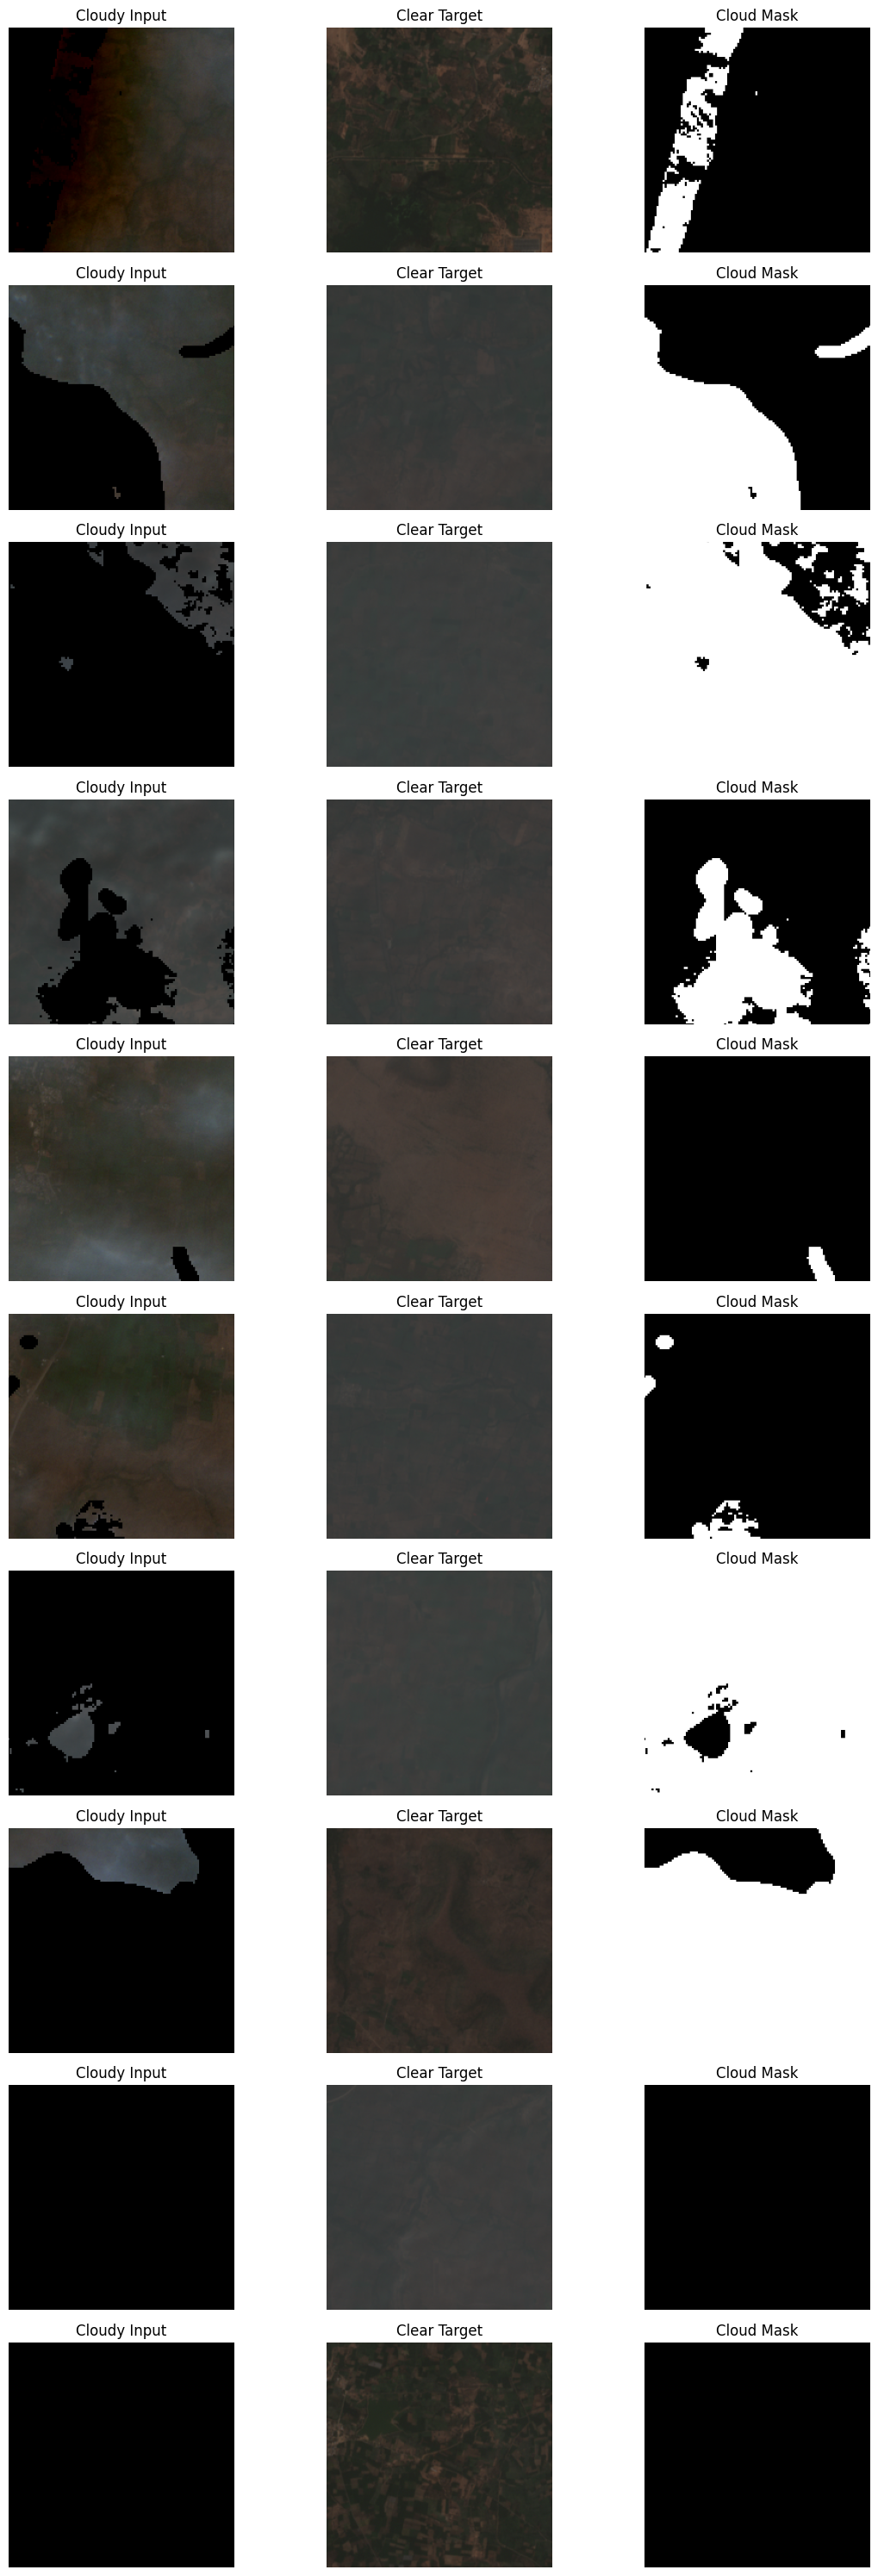

In [ ]:
import matplotlib.pyplot as plt

def show_samples(x, y, mask, n=4):
    """
    Show n samples from batch (cloudy, clear, mask side by side).
    """
    fig, axs = plt.subplots(n, 3, figsize=(12, 3*n))

    for i in range(n):
        cloudy = x[i].permute(1,2,0).numpy()
        clear  = y[i].permute(1,2,0).numpy()
        mask_  = mask[i][0].numpy()

        axs[i,0].imshow(cloudy)
        axs[i,0].set_title("Cloudy Input")
        axs[i,1].imshow(clear)
        axs[i,1].set_title("Clear Target")
        axs[i,2].imshow(mask_, cmap="gray")
        axs[i,2].set_title("Cloud Mask")

        for j in range(3):
            axs[i,j].axis("off")

    plt.tight_layout()
    plt.show()

# Example: show 4 samples from batch
show_samples(x_batch, y_batch, mask_batch, n=10)


In [ ]:
# =========================
# 1️⃣ Imports
# =========================
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

# =========================
# 2️⃣ Load Preprocessed Dataset
# =========================
data = torch.load("/content/dataset.pt")
x, y, mask = data["x"], data["y"], data["mask"]

# Optional simple augmentation function
def augment(batch_x, batch_y, batch_mask):
    if random.random() > 0.5:
        batch_x = batch_x.flip(-1)
        batch_y = batch_y.flip(-1)
        batch_mask = batch_mask.flip(-1)
    if random.random() > 0.5:
        batch_x = batch_x.flip(-2)
        batch_y = batch_y.flip(-2)
        batch_mask = batch_mask.flip(-2)
    return batch_x, batch_y, batch_mask

loader = DataLoader(TensorDataset(x, y, mask), batch_size=4, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# =========================
# 3️⃣ Model Definition
# =========================
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.enc1 = nn.Conv2d(3, 32, 3, padding=1)
        self.enc2 = nn.Conv2d(32, 64, 3, padding=1)
        self.enc3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2)

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec3 = nn.Conv2d(128, 64, 3, padding=1)
        self.dec2 = nn.Conv2d(64, 32, 3, padding=1)
        self.dec1 = nn.Conv2d(32, 3, 3, padding=1)

        self.relu = nn.ReLU()

    def forward(self, x):
        e1 = self.relu(self.enc1(x))
        e2 = self.relu(self.enc2(self.pool(e1)))
        e3 = self.relu(self.enc3(self.pool(e2)))
        d3 = self.relu(self.dec3(self.up(e3)))
        d2 = self.relu(self.dec2(self.up(d3)))
        out = self.dec1(d2)
        return out

model = SimpleCNN().to(device)

# =========================
# 4️⃣ Cloud-Only Loss (focus training only on cloud pixels)
# =========================
def cloud_only_mse(pred, target, mask):
    valid = mask
    denom = valid.sum()
    if denom < 1:
        return torch.tensor(0.0, device=pred.device, dtype=pred.dtype, requires_grad=True)
    diff = (pred - target) ** 2 * valid
    return diff.sum() / denom

# =========================
# 5️⃣ Optimizer & Training
# =========================
optimizer = optim.Adam(model.parameters(), lr=5e-5)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for x_batch, y_batch, mask_batch in loader:
        x_batch, y_batch, mask_batch = x_batch.to(device), y_batch.to(device), mask_batch.to(device)
        x_batch, y_batch, mask_batch = augment(x_batch, y_batch, mask_batch)

        optimizer.zero_grad()
        out = model(x_batch)

        # Loss only on cloud pixels
        loss = cloud_only_mse(out, y_batch, mask_batch)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(loader):.6f}")

# =========================
# 6️⃣ Save Model
# =========================
torch.save(model.state_dict(), "/content/simple_cnn_cloud.pth")
print("✅ Model saved!")

# =========================
# 7️⃣ Inference Helper with Mask Blur
# =========================
def restore_image(model, cloudy, mask, blur_kernel=3):
    model.eval()
    with torch.no_grad():
        cloudy, mask = cloudy.to(device).unsqueeze(0), mask.to(device).unsqueeze(0)

        pred = model(cloudy)

        # Smooth mask edges using average pooling
        mask_blur = F.avg_pool2d(mask, kernel_size=blur_kernel, stride=1, padding=blur_kernel//2)

        # Combine prediction in cloud areas, keep background exactly
        final = (1 - mask_blur) * cloudy + mask_blur * pred
        return final.squeeze(0).cpu()


Using device: cuda
Epoch 1/10, Loss: 0.031709
Epoch 2/10, Loss: 0.002956
Epoch 3/10, Loss: 0.002625
Epoch 4/10, Loss: 0.002635
Epoch 5/10, Loss: 0.002506
Epoch 6/10, Loss: 0.002315
Epoch 7/10, Loss: 0.002226
Epoch 8/10, Loss: 0.002132
Epoch 9/10, Loss: 0.002136
Epoch 10/10, Loss: 0.002138
✅ Model saved!


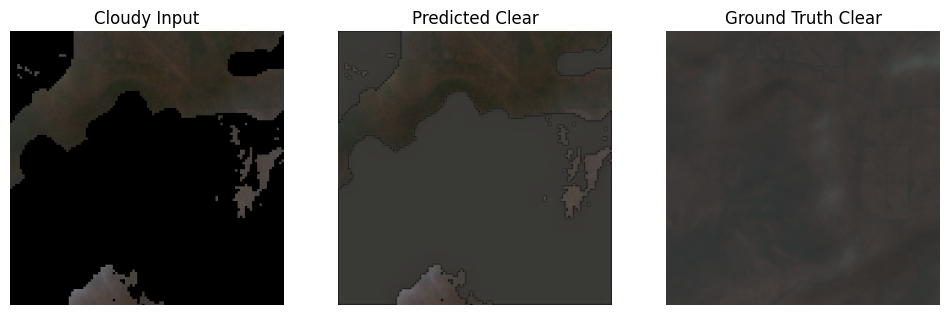

In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Set model to evaluation
model.eval()

# Get a batch from DataLoader
x_batch, y_batch, mask_batch = next(iter(loader))
x_batch, y_batch, mask_batch = x_batch.to(device), y_batch.to(device), mask_batch.to(device)

# Predict
with torch.no_grad():
    pred_raw = model(x_batch)

    # Smooth mask edges (optional)
    blur_kernel = 3
    mask_blur = F.avg_pool2d(mask_batch, kernel_size=blur_kernel, stride=1, padding=blur_kernel//2)

    # Combine network prediction only in cloud areas, keep background exactly
    pred = (1 - mask_blur) * x_batch + mask_blur * pred_raw

# Visualize the first patch
plt.figure(figsize=(12,4))

# Cloudy input
plt.subplot(1,3,1)
plt.title("Cloudy Input")
plt.imshow(x_batch[0].cpu().permute(1,2,0))
plt.axis('off')

# Model prediction (with background preserved)
plt.subplot(1,3,2)
plt.title("Predicted Clear")
plt.imshow(pred[0].cpu().permute(1,2,0))
plt.axis('off')

# Ground truth
plt.subplot(1,3,3)
plt.title("Ground Truth Clear")
plt.imshow(y_batch[0].cpu().permute(1,2,0))
plt.axis('off')

plt.show()


Using device: cuda
Epoch 1/10, Loss: 0.264664
Epoch 2/10, Loss: 0.087508
Epoch 3/10, Loss: 0.084971
Epoch 4/10, Loss: 0.084273
Epoch 5/10, Loss: 0.083059
Epoch 6/10, Loss: 0.080409
Epoch 7/10, Loss: 0.081577
Epoch 8/10, Loss: 0.078772
Epoch 9/10, Loss: 0.080141
Epoch 10/10, Loss: 0.080701
✅ Model saved!


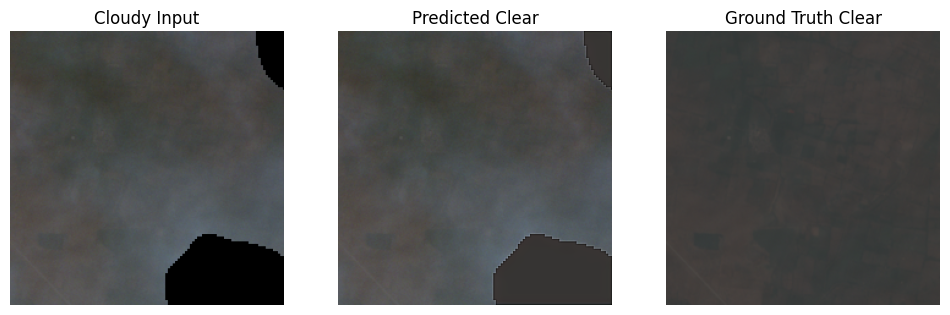

In [ ]:
# =========================
# 1️⃣ Imports
# =========================
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

# =========================
# 2️⃣ Load Preprocessed Dataset
# =========================
data = torch.load("/content/dataset.pt")
x, y, mask = data["x"], data["y"], data["mask"]

# Augmentation with optional color jitter on clouds
def augment(batch_x, batch_y, batch_mask):
    if random.random() > 0.5:
        batch_x = batch_x.flip(-1)
        batch_y = batch_y.flip(-1)
        batch_mask = batch_mask.flip(-1)
    if random.random() > 0.5:
        batch_x = batch_x.flip(-2)
        batch_y = batch_y.flip(-2)
        batch_mask = batch_mask.flip(-2)

    # Small random color jitter only on cloud regions
    noise = 0.02 * torch.randn_like(batch_x) * batch_mask
    batch_x = batch_x + noise
    return batch_x, batch_y, batch_mask

loader = DataLoader(TensorDataset(x, y, mask), batch_size=4, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# =========================
# 3️⃣ Model Definition (Residual CNN)
# =========================
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.enc1 = nn.Conv2d(3, 32, 3, padding=1)
        self.enc2 = nn.Conv2d(32, 64, 3, padding=1)
        self.enc3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2)

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec3 = nn.Conv2d(128, 64, 3, padding=1)
        self.dec2 = nn.Conv2d(64, 32, 3, padding=1)
        self.dec1 = nn.Conv2d(32, 3, 3, padding=1)

        self.relu = nn.ReLU()

    def forward(self, x):
        e1 = self.relu(self.enc1(x))
        e2 = self.relu(self.enc2(self.pool(e1)))
        e3 = self.relu(self.enc3(self.pool(e2)))
        d3 = self.relu(self.dec3(self.up(e3)))
        d2 = self.relu(self.dec2(self.up(d3)))
        residual = self.dec1(d2)
        out = x + residual  # Residual prediction
        return out

model = SimpleCNN().to(device)

# =========================
# 4️⃣ Cloud-Only Residual L1 Loss
# =========================
def cloud_only_residual_loss(pred, target, mask):
    # Compute residual
    residual = pred - x_batch
    target_residual = target - x_batch
    diff = (residual - target_residual) * mask
    loss = diff.abs().sum() / (mask.sum() + 1e-6)
    return loss

# =========================
# 5️⃣ Optimizer & Training
# =========================
optimizer = optim.Adam(model.parameters(), lr=5e-5)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for x_batch, y_batch, mask_batch in loader:
        x_batch, y_batch, mask_batch = x_batch.to(device), y_batch.to(device), mask_batch.to(device)
        x_batch, y_batch, mask_batch = augment(x_batch, y_batch, mask_batch)

        optimizer.zero_grad()
        out = model(x_batch)
        loss = cloud_only_residual_loss(out, y_batch, mask_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(loader):.6f}")

# =========================
# 6️⃣ Save Model
# =========================
torch.save(model.state_dict(), "/content/simple_cnn_cloud.pth")
print("✅ Model saved!")

# =========================
# 7️⃣ Inference Helper
# =========================
def restore_image(model, cloudy, mask, blur_kernel=3):
    model.eval()
    with torch.no_grad():
        cloudy, mask = cloudy.to(device).unsqueeze(0), mask.to(device).unsqueeze(0)
        pred_raw = model(cloudy)
        residual = pred_raw - cloudy

        # Smooth mask edges slightly
        mask_blur = F.avg_pool2d(mask, kernel_size=blur_kernel, stride=1, padding=blur_kernel//2)

        # Apply residual only on cloud areas
        final = cloudy + mask_blur * residual
        return final.squeeze(0).cpu().clamp(0,1)  # Clamp for visualization

# =========================
# 8️⃣ Visualization
# =========================
# Get a batch
x_batch, y_batch, mask_batch = next(iter(loader))
x_batch, y_batch, mask_batch = x_batch.to(device), y_batch.to(device), mask_batch.to(device)

with torch.no_grad():
    pred_raw = model(x_batch)
    residual = pred_raw - x_batch
    mask_blur = F.avg_pool2d(mask_batch, kernel_size=3, stride=1, padding=1)
    pred = x_batch + mask_blur * residual
    pred = pred.clamp(0,1)

# Visualize the first patch
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Cloudy Input")
plt.imshow(x_batch[0].cpu().permute(1,2,0))
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Predicted Clear")
plt.imshow(pred[0].cpu().permute(1,2,0))
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Ground Truth Clear")
plt.imshow(y_batch[0].cpu().permute(1,2,0))
plt.axis('off')

plt.show()
